<a href="https://colab.research.google.com/github/shebogholo/pytorch/blob/master/CNN_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
%matplotlib inline


# check if CUDA is available
if torch.cuda.is_available():
  print('CUDA is available!  Training on GPU')
else:
    print('CUDA is not available.  Training on CPU')

CUDA is available!  Training on GPU


In [0]:
# Hyper-parameters
num_workers = 0
batch_size = 20

# validation size
valid_size = 0.2

# data transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# training and test data
train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False, download=True, transform=transform)

# obtain indices for training and validation data
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# training and validation sampler
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# create data loaders for training, validation and test data
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size,
                                           sampler=train_sampler, 
                                           num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size,
                                           sampler=valid_sampler, 
                                           num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_data, 
                                          batch_size=batch_size, 
                                          num_workers=num_workers)

# image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


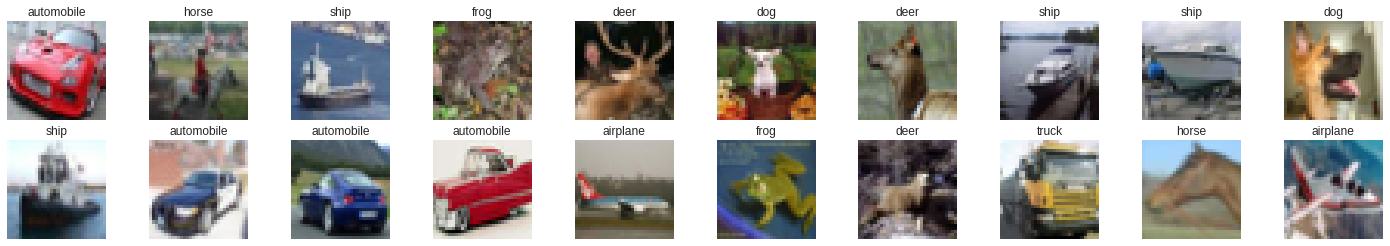

In [0]:
# unnormalize and display image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
# obtain one batch of training images
images, labels = next(iter(train_loader))
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))

num_display_images = 20  # number of images to display
for idx in np.arange(num_display_images):
    ax = fig.add_subplot(2, num_display_images/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [0]:
# Network Architecture (CNN)
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # (32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        
        # (16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        
        # (8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        
        # (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        
        # dropout probability 0.50
        self.dropout = nn.Dropout(0.50)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # flatten input image
        x = x.view(-1, 64 * 4 * 4)
        
        x = self.dropout(x)
        
        # add first hidden layer, with relu
        x = F.relu(self.fc1(x))
        
        # add dropout layer
        x = self.dropout(x)
        
        return self.fc2(x)

# intantiate CNNModel
model = CNNModel()

# if GPU is available, move tensors to GPU
if torch.cuda.is_available():
    model.cuda()

In [0]:
from torchsummary import summary
summary(model,(images.shape[1:]))    # input_size=(3, 32, 32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
         MaxPool2d-2           [-1, 16, 16, 16]               0
            Conv2d-3           [-1, 32, 16, 16]           4,640
         MaxPool2d-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          18,496
         MaxPool2d-6             [-1, 64, 4, 4]               0
           Dropout-7                 [-1, 1024]               0
            Linear-8                  [-1, 500]         512,500
           Dropout-9                  [-1, 500]               0
           Linear-10                   [-1, 10]           5,010
Total params: 541,094
Trainable params: 541,094
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.29
Params size (MB): 2.06
Estimated T

In [0]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [0]:
%%time
# number of epochs to train the model
n_epochs = 40

valid_loss_min = np.Inf

print('Training start...')
print('*' * 39)
print('Epoch \tTraining Loss \tValidation Loss')
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    model.train()
    for data, target in train_loader:
       
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
            
        optimizer.zero_grad()
        
        output = model(data)
        
        # calculate the batch loss
        loss = criterion(output, target)
        
        loss.backward()
        
        # update model parameters
        optimizer.step()
        
        # update training loss
        train_loss += loss.item()*data.size(0)
         
    # validate the model
    model.eval()
    for data, target in valid_loader:
      
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
      
        output = model(data)

        loss = criterion(output, target)
        
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
      
    # print training/validation statistics 
    print('{}\t\t{:.3f}\t\t{:.3f}'.format(epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        torch.save(model.state_dict(), 'cifar10_model.pt')
        valid_loss_min = valid_loss

Training start...
***************************************
Epoch 	Training Loss 	Validation Loss
1		1.716		0.369
2		1.377		0.313
3		1.240		0.286
4		1.158		0.266
5		1.089		0.249
6		1.031		0.236
7		0.983		0.222
8		0.938		0.213
9		0.903		0.204
10		0.872		0.197
11		0.837		0.194
12		0.815		0.187
13		0.789		0.178
14		0.771		0.179
15		0.753		0.175
16		0.736		0.167
17		0.720		0.167
18		0.702		0.160
19		0.687		0.162
20		0.675		0.160
21		0.665		0.156
22		0.654		0.151
23		0.642		0.157
24		0.632		0.154
25		0.622		0.146
26		0.610		0.147
27		0.598		0.145
28		0.588		0.150
29		0.581		0.149
30		0.574		0.147
31		0.566		0.144
32		0.565		0.141
33		0.554		0.139
34		0.547		0.138
35		0.540		0.137
36		0.531		0.138
37		0.529		0.134
38		0.520		0.136
39		0.518		0.132
40		0.510		0.138
CPU times: user 13min 49s, sys: 2min 43s, total: 16min 33s
Wall time: 16min 37s


In [0]:
model.load_state_dict(torch.load('cifar10_model.pt'))

In [0]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:

    if torch.cuda.is_available():
        data, target = data.cuda(), target.cuda()
        
    output = model(data)

    loss = criterion(output, target)
    
    test_loss += loss.item()*data.size(0)
    
    _, pred = torch.max(output, 1)    
    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
    
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.3f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 
            100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), 
            np.sum(class_total[i])))
    else:
        print('Test accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest accuracy: %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), 
    np.sum(class_total)))

Test Loss: 0.660

Test Accuracy of airplane: 80% (805/1000)
Test Accuracy of automobile: 88% (889/1000)
Test Accuracy of  bird: 68% (680/1000)
Test Accuracy of   cat: 54% (547/1000)
Test Accuracy of  deer: 77% (770/1000)
Test Accuracy of   dog: 68% (687/1000)
Test Accuracy of  frog: 85% (854/1000)
Test Accuracy of horse: 78% (786/1000)
Test Accuracy of  ship: 87% (879/1000)
Test Accuracy of truck: 84% (847/1000)

Test accuracy: 77% (7744/10000)


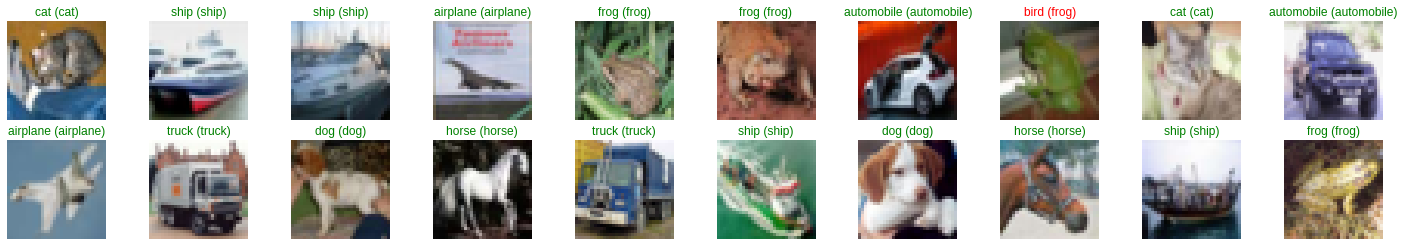

In [0]:
# obtain one batch of test images
images, labels = next(iter(test_loader))
images.numpy()

if torch.cuda.is_available():
    images = images.cuda()

# get sample outputs
output = model(images)

# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]), color=("green" if preds[idx]==labels[idx].item() else "red"))